# Top site list comparison analysis

In preparing to run our comparisons between crawl data and opt-in human browsing activity, we studied three well-known top site lists: Alexa, Majestic Million, and Tranco.
After making comparisons both between these lists and against a previous pilot dataset of opt-in human browsing, we decided to build the Trexa top site list combining the Alexa and Tranco lists.

This notebook provides some insight into these indivdual lists, how they match up against the Trexa list, and how close the Trexa list is to the top sites visited by the human users (reported with differential privacy protection).

In [1]:
from urllib.parse import urlparse
import math
import itertools
from collections import defaultdict

import numpy as np
import pandas as pd
import ggplot_utils as ggu
import dscitools as dst
from IPython.display import display, Image
import plotnine as gg
import mizani as scales
from tldextract import extract as tld_extract

## GGPlot
_ = gg.theme_set(gg.theme_light())

In [2]:
dst.print_status("Last updated")

__Last&nbsp;updated:&nbsp;&nbsp;Fri&nbsp;Apr&nbsp;24&nbsp;12:55:57&nbsp;2020__

## Top site lists

First, we study a few common top-site lists:

- [Alexa top 1M](https://s3.amazonaws.com/alexa-static/top-1m.csv.zip)
    * based on web traffic
- [Majestic Million](http://downloads.majestic.com/majestic_million.csv)
    * based on links
    * contains some common subdomains
- [Tranco top 1M](https://tranco-list.eu/top-1m.csv.zip)
    * combination of multiple top lists
    * should not contain subdomains

The latest version of each list is available at the indicated link. The lists referenced in this analysis were accessed in late July 2019 and are pulled from [here](https://github.com/mozilla/crawl-prep/tree/master/lists).

Each of these is loaded as a DataFrame with columns (`rank`, `url`), and we parse out the pay-level domains (PLDs).

In [3]:
def load_majestic_list():
    mm_df = pd.read_csv("lists/majestic_million.csv.gz")
    mm_df = mm_df[["GlobalRank", "IDN_Domain"]]
    mm_df.columns = ["rank", "url"]
    return mm_df
    

def load_alexa_list():
    a_df = pd.read_csv("lists/alexa-top1m.csv.gz", header=None)
    a_df.columns = ["rank", "url"]
    return a_df


def load_tranco_list():
    t_df = pd.read_csv("lists/tranco-1m.csv.gz", header=None)
    t_df.columns = ["rank", "url"]
    return t_df

In [4]:
def val_or_null(x):
    """Replace falsey values with None.
    
    This is particularly useful for empty strings.
    """
    return x if x else None


def apply_urlparse(url):
    """Apply `urlparse` to a URL that may be missing a scheme.
    
    Extracts the scheme and netloc (returned as a dict).
    """
    if "://" not in url:
        url = "//" + url
    parsed = urlparse(url)
    return {
        "scheme": val_or_null(parsed.scheme),
        "netloc": val_or_null(parsed.netloc)
    }


def apply_tldextract(url):
    """Extract subdomain and pay-level domain with `tldextract`.
    
    Returned as a dict.
    """
    parsed = tld_extract(url)
    return {
        "subdomain": val_or_null(parsed.subdomain),
        "pld": val_or_null(parsed.registered_domain)
    }


def parse_list_urls(df):
    """Parse out components of the list URLs into additional columns.
    
    Expects a DF with a `url` column.
    
    Returns a DF with additional columns `scheme`, `netloc`, `subdomain` and `pld`.
    """
    urlparse_result = df["url"].map(apply_urlparse)
    tldextract_result = df["url"].map(apply_tldextract)
    
    df = df.copy()
    df.loc[:, "scheme"] = urlparse_result.map(lambda x: x["scheme"])
    df.loc[:, "netloc"] = urlparse_result.map(lambda x: x["netloc"])
    df.loc[:, "subdomain"] = tldextract_result.map(lambda x: x["subdomain"])
    df.loc[:, "pld"] = tldextract_result.map(lambda x: x["pld"])
    
    return df

In [5]:
alexa_list = parse_list_urls(load_alexa_list())
majestic_list = parse_list_urls(load_majestic_list())
tranco_list = parse_list_urls(load_tranco_list())

In [6]:
alexa_list.head(3)

,rank,url,scheme,netloc,subdomain,pld
0,1,google.com,None,google.com,None,google.com
1,2,youtube.com,None,youtube.com,None,youtube.com
2,3,tmall.com,None,tmall.com,None,tmall.com


In [7]:
majestic_list.head(3)

,rank,url,scheme,netloc,subdomain,pld
0,1,google.com,None,google.com,None,google.com
1,2,facebook.com,None,facebook.com,None,facebook.com
2,3,youtube.com,None,youtube.com,None,youtube.com


In [8]:
tranco_list.head(3)

,rank,url,scheme,netloc,subdomain,pld
0,1,google.com,None,google.com,None,google.com
1,2,facebook.com,None,facebook.com,None,facebook.com
2,3,netflix.com,None,netflix.com,None,netflix.com


### Summary stats

Print some summaries and check for occurrences of certain edge cases. As we want to work with PLDs, we also check how often we see multiple subdomains listed for the same PLD.

In [9]:
def print_list_summary(df):
    """Print some summary stats about a top site list.
    
    Results focus on PLDs and subdomains appearing in the list.
    
    Expects a DF as output by `parse_list_urls()`.
    """
    def pld_in_subset(pld_df, subset_df, col_name):
        """Add a boolean column to a main list of PLDs indicating whether they appear in a subset."""
        subset_plds = subset_df[["pld"]].drop_duplicates()
        subset_plds[col_name] = True
        return (
            pd.merge(
                pld_df,
                subset_plds,
                on="pld",
                how="left"
            )
            .fillna(False)
        )
    
    all_pld = df[df["pld"].notnull()][["pld"]].drop_duplicates()
    ## Missing subdomain
    all_pld = pld_in_subset(
        all_pld,
        df[df["subdomain"].isna()],
        "has_no_sd"
    )
    ## Standard (www) subdomain.
    all_pld = pld_in_subset(
        all_pld,
        df[df["subdomain"] == "www"],
        "has_www_sd"
    )
    ## Other subdomains.
    all_pld = pld_in_subset(
        all_pld,
        df[(df["subdomain"].notna()) & (df["subdomain"] != "www")],
        "has_other_sd"
    )
        
    num_entries = len(df)
    dst.fmt_count(
        num_entries,
        "Num list entries"
    )
    dst.fmt_count(
        df["scheme"].notnull().sum(),
        "Num entries including protocol (edge case)",
        num_entries,
        "entries",
        show_n_overall=False
    )
    dst.fmt_count(
        (df["netloc"] != df["url"]).sum(),
        "Num entries with additional components beyond netloc (edge case)",
        num_entries,
        "entries",
        show_n_overall=False
    )
    dst.fmt_count(
        df["pld"].isnull().sum(),
        "Num non-PLD entries (edge case)",
        num_entries,
        "entries",
        show_n_overall=False
    )
    print("")
    
    num_unique_tlds = len(all_pld)
    dst.fmt_count(
        num_unique_tlds,
        "Num unique TLDs",
        num_entries,
        "entries",
        show_n_overall=False
    )
    dst.fmt_count(
        ((df["subdomain"].notnull()) & (df["pld"].notnull())).sum(),
        "Num entries with subdomain",
        num_entries,
        "entries",
        show_n_overall=False
    )
    print("")
    
    dst.fmt_count(
        ((~all_pld["has_www_sd"]) & (~all_pld["has_other_sd"])).sum(),
        "Num unique PLDs never including subdomain",
        num_unique_tlds,
        "PLDs",
        show_n_overall=False
    )
    dst.fmt_count(
        all_pld["has_www_sd"].sum(),
        "Num unique PLDs including 'www' subdomain",
        num_unique_tlds,
        "PLDs",
        show_n_overall=False
    )
    dst.fmt_count(
        ((all_pld["has_www_sd"]) & (~all_pld["has_other_sd"]) & (~all_pld["has_no_sd"])).sum(),
        "Num unique PLDs with 'www' subdomain only",
        num_unique_tlds,
        "PLDs",
        show_n_overall=False
    )
    dst.fmt_count(
        all_pld["has_other_sd"].sum(),
        "Num unique PLDs including other subdomains",
        num_unique_tlds,
        "PLDs",
        show_n_overall=False
    )


def top_plds_with_subdomains(df, limit=10):
    return (
        df[df["subdomain"].notnull()]
        .groupby("pld", as_index=False)
        .agg({"url": "count", "rank": "min"})
        .rename(columns={"url": "num_entries", "rank": "min_rank"})
        .sort_values("min_rank")
        .reset_index(drop=True)
        .head(limit)
    )

#### Alexa:

- Most entries have no subdomains
- Hardly any entries with `www` subdomain

In [10]:
print_list_summary(alexa_list)

Num list entries:  992,661
Num entries including protocol (edge case):  0  (0.00% of entries)
Num entries with additional components beyond netloc (edge case):  0  (0.00% of entries)
Num non-PLD entries (edge case):  12  (0.00% of entries)

Num unique TLDs:  932,497  (93.94% of entries)
Num entries with subdomain:  60,461  (6.09% of entries)

Num unique PLDs never including subdomain:  932,069  (99.95% of PLDs)
Num unique PLDs including 'www' subdomain:  21  (0.00% of PLDs)
Num unique PLDs with 'www' subdomain only:  5  (0.00% of PLDs)
Num unique PLDs including other subdomains:  423  (0.05% of PLDs)


Top PLDs with subdomains:

In [11]:
top_plds_with_subdomains(alexa_list)

,pld,num_entries,min_rank
0,tmall.com,358,11
1,blogspot.com,29122,417
2,wordpress.com,7004,469
3,wix.com,49,815
4,uol.com.br,110,1026
5,tumblr.com,2691,1073
6,msk.ru,141,1301
7,go.com,12,1343
8,squarespace.com,305,1744
9,googleapis.com,16,1750


#### Majestic:

- Vast majority of entries have no subdomains
- Most sites reporting `www` subdomain appear with that only

In [12]:
print_list_summary(majestic_list)

Num list entries:  1,000,000
Num entries including protocol (edge case):  0  (0.00% of entries)
Num entries with additional components beyond netloc (edge case):  0  (0.00% of entries)
Num non-PLD entries (edge case):  1,018  (0.10% of entries)

Num unique TLDs:  997,571  (99.76% of entries)
Num entries with subdomain:  1,665  (0.17% of entries)

Num unique PLDs never including subdomain:  996,854  (99.93% of PLDs)
Num unique PLDs including 'www' subdomain:  201  (0.02% of PLDs)
Num unique PLDs with 'www' subdomain only:  171  (0.02% of PLDs)
Num unique PLDs including other subdomains:  541  (0.05% of PLDs)


Top PLDs with subdomains:

In [13]:
top_plds_with_subdomains(majestic_list)

,pld,num_entries,min_rank
0,google.com,15,10
1,wikipedia.org,8,11
2,apple.com,4,13
3,vimeo.com,1,26
4,godaddy.com,2,35
5,adobe.com,2,39
6,nih.gov,1,60
7,europa.eu,1,65
8,w3.org,2,80
9,facebook.com,4,83


#### Tranco:

- Clean list with practically no subdomains
- This means, eg. all Google properties are aggregated together

In [14]:
print_list_summary(tranco_list)

Num list entries:  1,000,000
Num entries including protocol (edge case):  0  (0.00% of entries)
Num entries with additional components beyond netloc (edge case):  0  (0.00% of entries)
Num non-PLD entries (edge case):  6  (0.00% of entries)

Num unique TLDs:  999,833  (99.98% of entries)
Num entries with subdomain:  166  (0.02% of entries)

Num unique PLDs never including subdomain:  999,828  (100.00% of PLDs)
Num unique PLDs including 'www' subdomain:  3  (0.00% of PLDs)
Num unique PLDs with 'www' subdomain only:  0  (0.00% of PLDs)
Num unique PLDs including other subdomains:  5  (0.00% of PLDs)


In [15]:
top_plds_with_subdomains(tranco_list)

,pld,num_entries,min_rank
0,gov.ru,82,7839
1,edu.ru,50,20137
2,mil.ru,16,71416
3,ac.ru,17,170426
4,k12.ri.us,1,740404


### Pay-level domains

Normalize the lists by retaining only valid PLDs. For cases where a PLD appears multiple times with different subdomains, we retain only the highest-ranked occurrence.

In [16]:
def pld_list_from_ranked(df):
    """Extract a top-PLD list by retaining the highest ranked occurrence.
    
    Expects a DF as output by `parse_list_urls()`.
    
    Returns a DF with columns (`pld`, `ref_rank`).
    """
    plds = (
        df.loc[df["pld"].notna(), ["pld"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    plds["ref_rank"] = np.arange(len(plds)) + 1
    return plds

In [17]:
alexa_plds = pld_list_from_ranked(alexa_list)
majestic_plds = pld_list_from_ranked(majestic_list)
tranco_plds = pld_list_from_ranked(tranco_list)

In [18]:
tranco_plds.head()

,pld,ref_rank
0,google.com,1
1,facebook.com,2
2,netflix.com,3
3,youtube.com,4
4,twitter.com,5


Take a look at the combined lists:

In [19]:
pld_lists_combined = pd.DataFrame({ 
    "alexa": alexa_plds["pld"],
    "majestic": majestic_plds["pld"],
    "tranco": tranco_plds["pld"]
})

In [20]:
pld_lists_combined.head(20)

,alexa,majestic,tranco
0,google.com,google.com,google.com
1,youtube.com,facebook.com,facebook.com
2,tmall.com,youtube.com,netflix.com
3,baidu.com,twitter.com,youtube.com
4,qq.com,linkedin.com,twitter.com
5,facebook.com,instagram.com,amazon.com
6,taobao.com,microsoft.com,microsoft.com
7,sohu.com,wikipedia.org,baidu.com
8,yahoo.com,apple.com,wikipedia.org
9,wikipedia.org,adobe.com,linkedin.com


### List comparisons

How well do the lists agree with each other? We plot the Jaccard similarity between all combinations of the lists.

For a collection of lists, the Jaccard similarity is computed as `intersection / union` of the top K entries, for each K.

In [21]:
def compute_list_similarities(list_dict, limit=None):
    """Compute Jaccard similarity between all combinations of a set of top site lists.
    
    Lists should be specified as a dict mapping list names to lists.
    
    Similarity is computed between the top k entries on each list
    for all k.
    
    Returns a DF with columns listing the similarity for every combination
    of the lists for each k.
    """
    max_k = min([len(x) for x in list_dict.values()])
    if limit:
        max_k = min(limit, max_k)
    list_names = list_dict.keys()
    all_combos = list(itertools.chain.from_iterable(
        itertools.combinations(list_names, r) for r in range(2, len(list_names)+1)
    ))
    current_sets = {nm: set() for nm in list_names}
    current_unions = {c: set() for c in all_combos}
    current_intersections = {c: set() for c in all_combos}
    similarities = {c: [] for c in all_combos}
    
    for i in range(max_k):
        for combo, sim in similarities.items():
            union = current_unions[combo]
            intersect = current_intersections[combo]
            for nm in combo:
                xi = list_dict[nm][i]
                current_sets[nm].add(xi)
                union.add(xi)
            for nm in combo:
                xi = list_dict[nm][i]
                in_all_sets = [
                    xi in current_sets[nm2]
                    for nm2 in combo if nm2 != nm
                ]
                if np.all(in_all_sets):
                    intersect.add(xi)
            sim.append(len(intersect) / len(union))
    df_cols = {"|".join(combo): x for combo, x in similarities.items()}
    df_cols["k"] = np.arange(max_k) + 1
    return pd.DataFrame(df_cols)

In [22]:
pld_lists = {
    "Alexa": alexa_plds["pld"].values,
    "Majestic": majestic_plds["pld"].values,
    "Tranco": tranco_plds["pld"].values
}

In [23]:
%%time

top_list_sim = compute_list_similarities(pld_lists, limit=100000)

CPU times: user 5.11 s, sys: 56.9 ms, total: 5.16 s
Wall time: 5.2 s


- Tranco settles at around 40% similarity with the other two lists. This is not surprising, as Tranco is constructed as a hybrid list.
- Similarity between Alexa and Majestic is much lower, at around 20% or less.

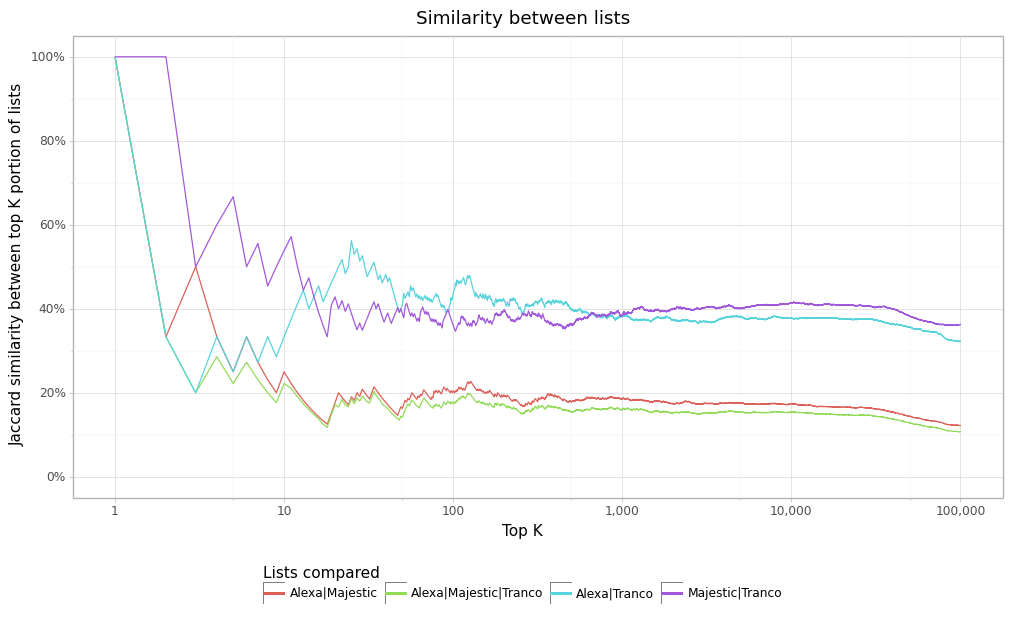

<ggplot: (356901733)>

In [24]:
plot_df = pd.melt(
    top_list_sim,
    id_vars="k",
    var_name="combo",
    value_name="similarity"
)

display(
    gg.ggplot(
        plot_df,
        gg.aes("k", "similarity", colour="combo")
    ) +
    gg.geom_line() +
    ggu.x_log10_fmt() +
    ggu.y_pct_fmt_full() +
    gg.expand_limits(y=0) +
    ggu.figsize(12, 6) +
    gg.labs(
        title="Similarity between lists",
        x="Top K",
        y="Jaccard similarity between top K portion of lists",
        color="Lists compared" 
    ) +
    ggu.bottom_legend()
)

Get an idea of the differences between the lists. For each list, show only the sites in the top K which are not in the top K of either of the others, ie. sites that are _not_ in the union of the other lists' top K. We run this for K = 50. These non-overlapping sites are displayed at their respective positions in their lists.

In [25]:
def list_diff_df(pld_lists, k_top):
    pld_list_diff = defaultdict(list)
    for nm, plds in pld_lists.items():
        other_lists = set()
        for a, x in pld_lists.items():
            if a != nm:
                other_lists.update(x[:k_top])
        for i, pld in enumerate(plds[:k_top]):
            if pld not in other_lists:
                pld_list_diff[nm].append((i + 1, pld))

    pld_list_diff_df = pd.DataFrame({"rank": range(1, k_top)})
    for nm, dd in pld_list_diff.items():
        df = pd.DataFrame.from_records(dd, columns=["rank", nm])
        pld_list_diff_df = pd.merge(
            pld_list_diff_df,
            df,
            on="rank",
            how="outer"
        )
    return (
        pld_list_diff_df
        .sort_values("rank")
        .fillna("")
        .reset_index(drop=True)
    )

In [26]:
list_diff_df(pld_lists, 50)

,rank,Alexa,Majestic,Tranco
0,1,,,
1,2,,,
2,3,,,
3,4,,,
4,5,,,
5,6,,,
6,7,,,
7,8,,,
8,9,,,
9,10,,,


## Trexa list

The Trexa list is formed by interleaving the Alexa and Tranco lists, retaining the lower rank for sites appearing in both. The goal in using the Trexa list is to boost the diversity of the Tranco list, itself a hybrid list, by essentially weighting Alexa more heavily.

We developed the Trexa list after studying how well the standard lists match up against opt-in human browsing from a previous pilot study ("JESTr"). While we are not able to publish that analysis in full due to privacy implications, the following provides an example of the results we saw. The left panel was prepared by computing the cumulative frequency of navigation events, rank-ordered by frequency of associated PLDs, and plotting against how far down each reference list we need to go to cover all the PLDs associated with these events. The right panel is similar, computed for request events.

- Tranco and Alexa perform similarly well in both cases.
- Tranco seems better suited to navigation events than the other lists
- Majestic is the worst performer in both cases

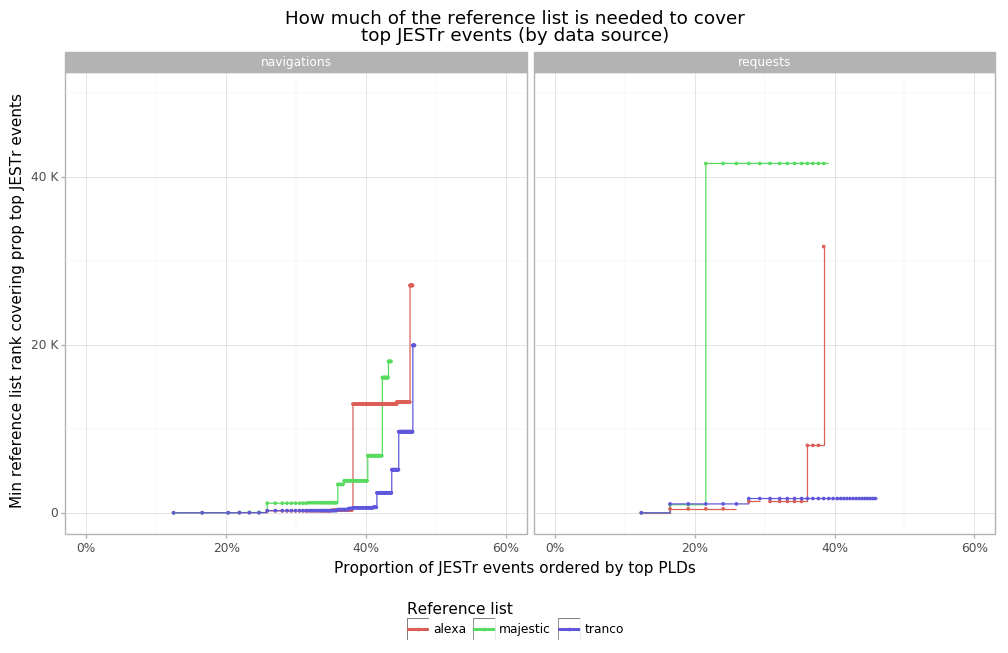

In [27]:
Image("jestr_plds.png")

We now look into how closely the Trexa list matches up with the lists discussed above.

First, load the Trexa list and print some summary stats

In [28]:
def load_trexa_list():
    trexa_df = pd.read_csv("lists/trexa_10k.csv", header=None)
    trexa_df.columns = ["url"]
    trexa_df["rank"] = np.arange(len(trexa_df)) + 1
    return trexa_df

In [29]:
trexa_list = parse_list_urls(load_trexa_list())

In [30]:
trexa_list.head()

,url,rank,scheme,netloc,subdomain,pld
0,google.com,1,None,google.com,None,google.com
1,youtube.com,2,None,youtube.com,None,youtube.com
2,facebook.com,3,None,facebook.com,None,facebook.com
3,tmall.com,4,None,tmall.com,None,tmall.com
4,netflix.com,5,None,netflix.com,None,netflix.com


In [31]:
print_list_summary(trexa_list)

Num list entries:  14,556
Num entries including protocol (edge case):  0  (0.00% of entries)
Num entries with additional components beyond netloc (edge case):  0  (0.00% of entries)
Num non-PLD entries (edge case):  0  (0.00% of entries)

Num unique TLDs:  14,404  (98.96% of entries)
Num entries with subdomain:  153  (1.05% of entries)

Num unique PLDs never including subdomain:  14,385  (99.87% of PLDs)
Num unique PLDs including 'www' subdomain:  0  (0.00% of PLDs)
Num unique PLDs with 'www' subdomain only:  0  (0.00% of PLDs)
Num unique PLDs including other subdomains:  19  (0.13% of PLDs)


In [32]:
trexa_plds = pld_list_from_ranked(trexa_list)

In [33]:
trexa_plds.head()

,pld,ref_rank
0,google.com,1
1,youtube.com,2
2,facebook.com,3
3,tmall.com,4
4,netflix.com,5


### Coverage

For each K, how far down the Trexa list do we need to go to cover the top K of each reference list?

In [34]:
def compute_coverage_dataset(ref_list,
                             candidate_list,
                             limit=None):
    """Compute the rank of a candidate list needed to cover the top K
    of a reference list, for each K.
    
    `ref_list` and `candidate_list` should both be DFs with columns (`pld`, `ref_rank`).
    
    Returns a DF with columns (`pld`, `ref_rank`, `candidate_rank`, `ref_cum_max`).
    """
    candidate_list = candidate_list.copy().rename(columns={"ref_rank": "candidate_rank"})
    df = pd.merge(
        ref_list,
        candidate_list,
        how="outer",
        on="pld"
    ).sort_values("ref_rank")
    
    if limit:
        df = df[:limit]
    df["candidate_cum_max"] = df["candidate_rank"].cummax()
    return df

In [35]:
pld_dfs = {
    "Alexa": alexa_plds,
    "Majestic": majestic_plds,
    "Tranco": tranco_plds
}

In [36]:
coverage_dfs = []
for nm, plds in pld_dfs.items():
    cov_df = compute_coverage_dataset(plds, trexa_plds)
    cov_df["ref_list"] = nm
    coverage_dfs.append(cov_df)
    
coverage_comp = pd.concat(coverage_dfs, ignore_index=True)

- As expected, both Alexa and Tranco are consistenly well-covered by the Trexa list. Since the Trexa list is formed by interleaving, sites further down each list can appear at a rank up to twice as high in Trexa, so the coverage is not expected to be 1-to-1.
- Coverage for the Majestic Million sites is not as close, but Trexa still does a decent job: the top K Majestic sites are covered by the top 4-5K Trexa sites.

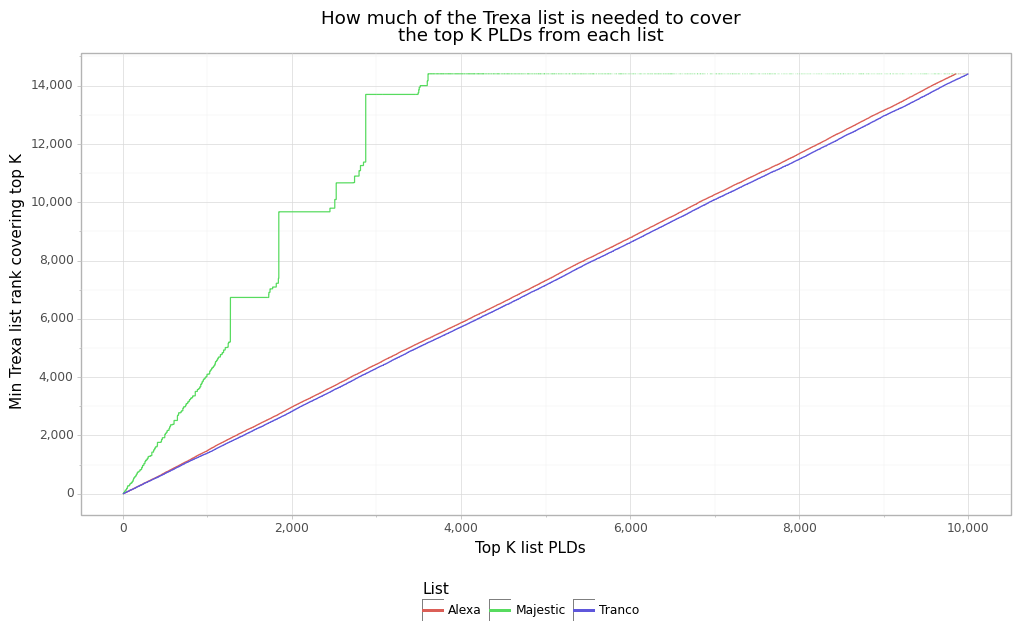

<ggplot: (342856377)>

In [37]:
(
    gg.ggplot(
        coverage_comp[coverage_comp.ref_rank <= 10000],
        gg.aes("ref_rank", "candidate_cum_max", colour="ref_list")
    ) +
    gg.geom_step() +
    ggu.x_comma_fmt(breaks=ggu.interval_breaks(2000)) +
    ggu.y_comma_fmt(breaks=ggu.interval_breaks(2000)) +
    ggu.figsize(12,6) +
    gg.labs(
        title="How much of the Trexa list is needed to cover" +
            "\nthe top K PLDs from each list",
        x="Top K list PLDs",
        y="Min Trexa list rank covering top K",
        color="List" 
    ) +
    ggu.bottom_legend()
)

### Overlap

For each K, what proportion of each list's top K sites are in the Trexa top K?

In [38]:
def compute_overlap_for_k(ref_ranks, k_vals):
    """Compute the overlap proportions in a rank list for various cutoffs.
    
    Ranks should be given as an array-like `ref_ranks`, ordered by the other ranking
    this is comparing against. Overlap will then be the proportion of the top k
    of `ref_ranks` which have values at most k.
    
    This will be computed for all k values in the `k_vals` array-like.
    
    Returns a list of overlap proportions.
    """
    return [(ref_ranks[:k] <= k).mean() for k in k_vals]


def compute_overlap_dataset(ref_list,
                            candidate_list,
                            limit=None,
                            overlap_step=1):
    """Combine rank lists and compute overlap proportions for various k.
    
    k increases by `overlap_step` each time.
    
    Returns a DF with columns (`pld`, `ref_rank`, `candidate_rank`, `ref_overlap`).
    """
    candidate_list = candidate_list.copy().rename(columns={"ref_rank": "candidate_rank"})
    df = pd.merge(
        ref_list,
        candidate_list,
        how="outer",
        on="pld"
    ).sort_values("ref_rank")
    if limit:
        df = df[:limit]

    overlap_k_vals = np.arange(
        start=overlap_step,
        stop=len(df) + 1,
        step=overlap_step
    )
    ref_overlap = compute_overlap_for_k(df["candidate_rank"], overlap_k_vals)
    overlap_df = pd.DataFrame({
        "ref_rank": overlap_k_vals,
        "ref_overlap": ref_overlap
    })
    df = pd.merge(
        df,
        overlap_df,
        on="ref_rank",
        how="left"
    )
    return df




In [39]:
overlap_dfs = []
for nm, plds in pld_dfs.items():
    ol_df = compute_overlap_dataset(plds, trexa_plds, limit=10000)
    ol_df["ref_list"] = nm
    overlap_dfs.append(ol_df)
    
overlap_comp = pd.concat(overlap_dfs, ignore_index=True)

- The proportions stabilize after K = 2000
- Overlap with Alexa and Tranco is high (70-80%), suggesting that the interleaving approach gives good agreement with both lists.
- Overlap with Majestic settles at around 45%, which is higher than the original overlaps with either Alexa or Tranco individually

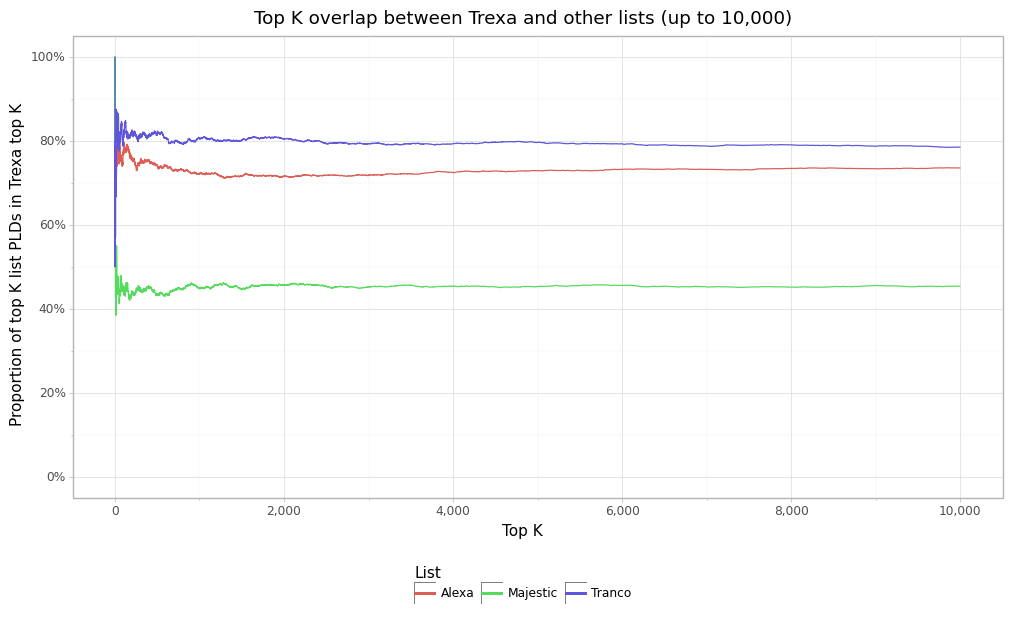

<ggplot: (372511449)>

In [40]:
display(
    gg.ggplot(
        overlap_comp,
        gg.aes("ref_rank", "ref_overlap", colour="ref_list")
    ) +
    gg.geom_line() +
    ggu.y_pct_fmt_full() +
    gg.expand_limits(y=0) +
    ggu.x_comma_fmt(breaks=ggu.interval_breaks(2000)) +
#     gg.scale_x_continuous(labels=ggu.large_num_labels()) +
    ggu.figsize(12, 6) +
    gg.labs(
        title="Top K overlap between Trexa and other lists (up to 10,000)",
        x="Top K",
        y="Proportion of top K list PLDs in Trexa top K",
        color="List" 
    ) +
    ggu.bottom_legend()
)